# Explore STEREO-seq - quick analysis

In [1]:
https://github.com/saeyslab/napari-sparrow/blob/main/docs/installation.md

# Load libraries (kernel: napari-sparrow)

import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

from dask.distributed import Client

## Related to single-cell
from anndata import AnnData
import scanpy as sc
import squidpy as sq
from cellpose import models, io

## Related to geometry
import geopandas
# import rasterio
# from rasterio import features
# import shapely
# from shapely.geometry import Point, Polygon

from napari_sparrow import functions as fc

the value of the environment variable BASIC_DCT_BACKEND is not in ["JAX","SCIPY"]


In [2]:
# Define files

import win32com.client
shell = win32com.client.Dispatch("WScript.Shell")

## Root paths
paths = {"root": "../../.."}
paths.update({"data_raw": shell.CreateShortCut(paths["root"] + "/data_raw.lnk").Targetpath,
              "data_pro": paths["root"] + "/data_processed",
              "process" : paths["root"] + "/processing"})

## Input
paths.update({"image-wall": paths["data_raw"] + "/C01828B1/C01828B1_FB.regist.tif"})
paths.update({"gem": paths["data_raw"] + "/C01828B1.raw.gem"})

In [3]:
# Load data

## Raw cell-wall image
img_wall_raw_ic = sq.im.ImageContainer(io.imread(paths["image-wall"]))

## Convert image to numpy
img_wall_raw_np = img_wall_raw_ic.data.image.squeeze().to_numpy()

# Transcript data (.gem) into a dask dataframe
paths.update({"gem": paths["data_raw"] + "/C01828B1.raw.gem"})
ddf = fc.read_in_stereoSeq(paths["gem"], skiprows = 6, xcol = 'x', ycol = 'y')

---

# Summary

This is a quick analysis of STEREO-seq data:

- image pre-processing and segmentation
- transcripts allocation to cell
- some visual checks, including known marker genes.

Both data and processing seem good.

---

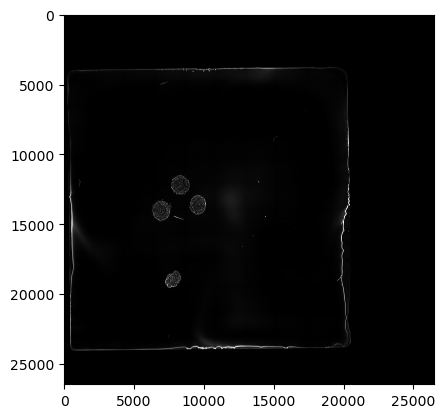

In [4]:
# Plot full image
plt.imshow(img_wall_raw_np, cmap = 'gray')

In [5]:
# Define better coordinates
crd_slice = (slice(11000, 20000), slice(5000, 11000))
crd_list  = [      11000, 20000,        5000, 11000]

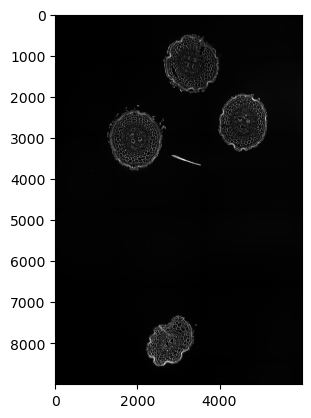

In [6]:
# Plot zoom-in image

plt.imshow(img_wall_raw_np[crd_slice], cmap = 'gray')

In [7]:
# Preproces image
img_wall_clean_ic = fc.preprocessImage(img_wall_raw_ic, 
                                       size_tophat   = 105,
                                       contrast_clip = 1.5)

# Convert to numpy
img_wall_clean_np = img_wall_clean_ic.data.image.squeeze().to_numpy()

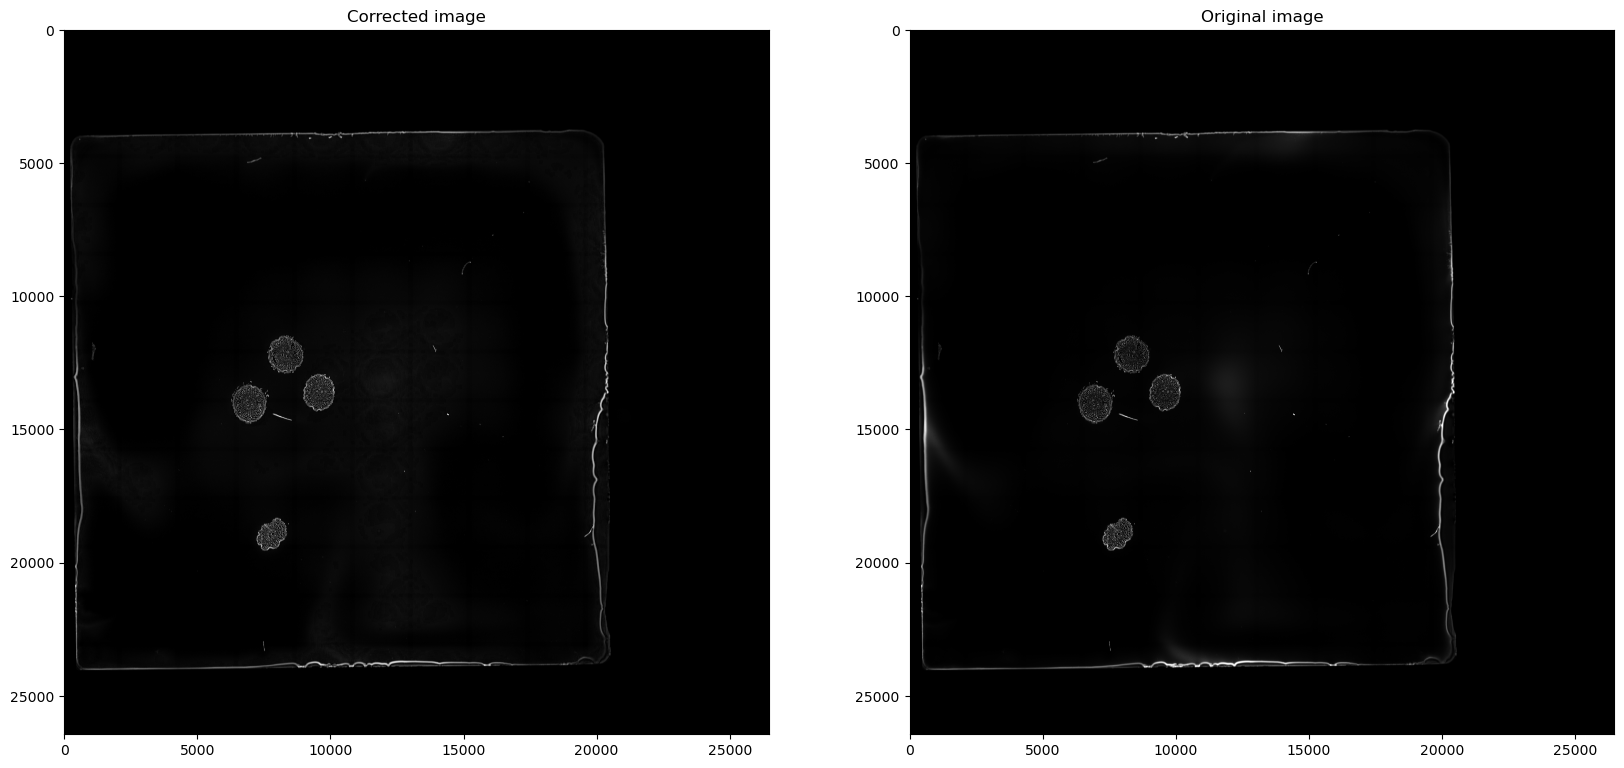

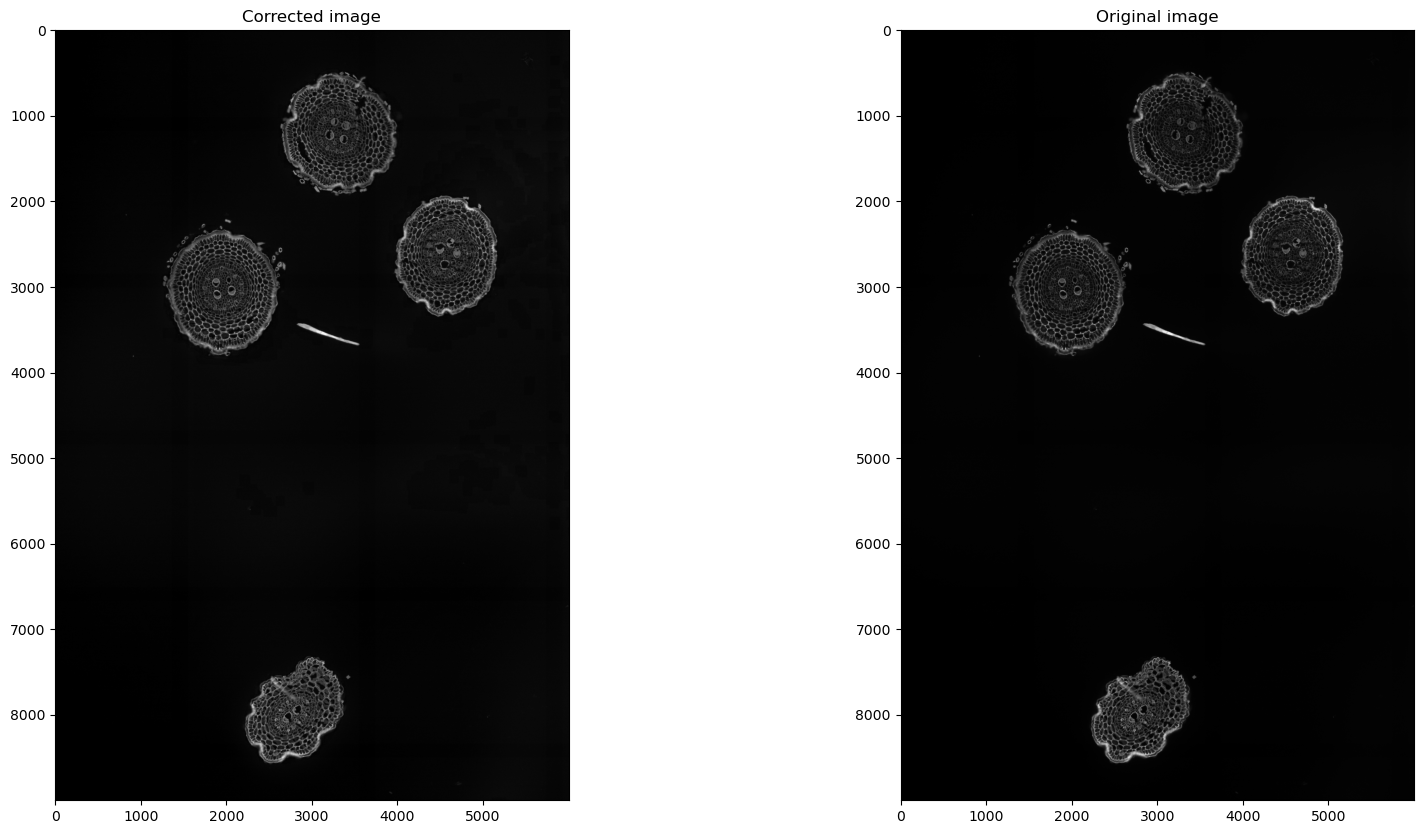

In [10]:
# Plot preprocessed image
fc.preprocessImagePlot(img      = img_wall_clean_np,
                       img_orig = img_wall_raw_np,
                       small_size_vis = crd_list)

# Segmentation

In [11]:
client = Client(n_workers          = 1,
                threads_per_worker = 1,
                memory_limit       = '50GB',
                local_directory    = '/srv/scratch',
                dashboard_address  = 42738)
client

<Client: 'tcp://127.0.0.1:54583' processes=1 threads=1, memory=46.57 GiB>

In [ ]:
# Segment (only on the first run)

masks,mask_i,polygons,img = fc.segmentation(img                = img_wall_clean_ic,
                                            # device           = 'cuda:4',
                                            min_size           = 80,
                                            flow_threshold     = 0.85,
                                            diameter           = 60,
                                            cellprob_threshold = -4,
                                            model_type         = "cyto",
                                            channels           = [1,0])

In [ ]:
# Temporary: load/Save segmentation results (as pickle files)

# import pickle

## Save

# with open('stash/masks.pickle', 'wb') as file:
#     pickle.dump(masks, file)

# with open('stash/mask_i.pickle', 'wb') as file:
#     pickle.dump(mask_i, file)

# with open('stash/polygons.pickle', 'wb') as file:
#     pickle.dump(polygons, file)

# with open('stash/img.pickle', 'wb') as file:
#     pickle.dump(img, file)

## Load

# with open('stash/masks.pickle', 'rb') as file:
#     masks = pickle.load(file)

# with open('stash/mask_i.pickle', 'rb') as file:
#     mask_i = pickle.load(file)

# with open('stash/polygons.pickle', 'rb') as file:
#     polygons = pickle.load(file)

# with open('stash/img.pickle', 'rb') as file:
#     img = pickle.load(file) 

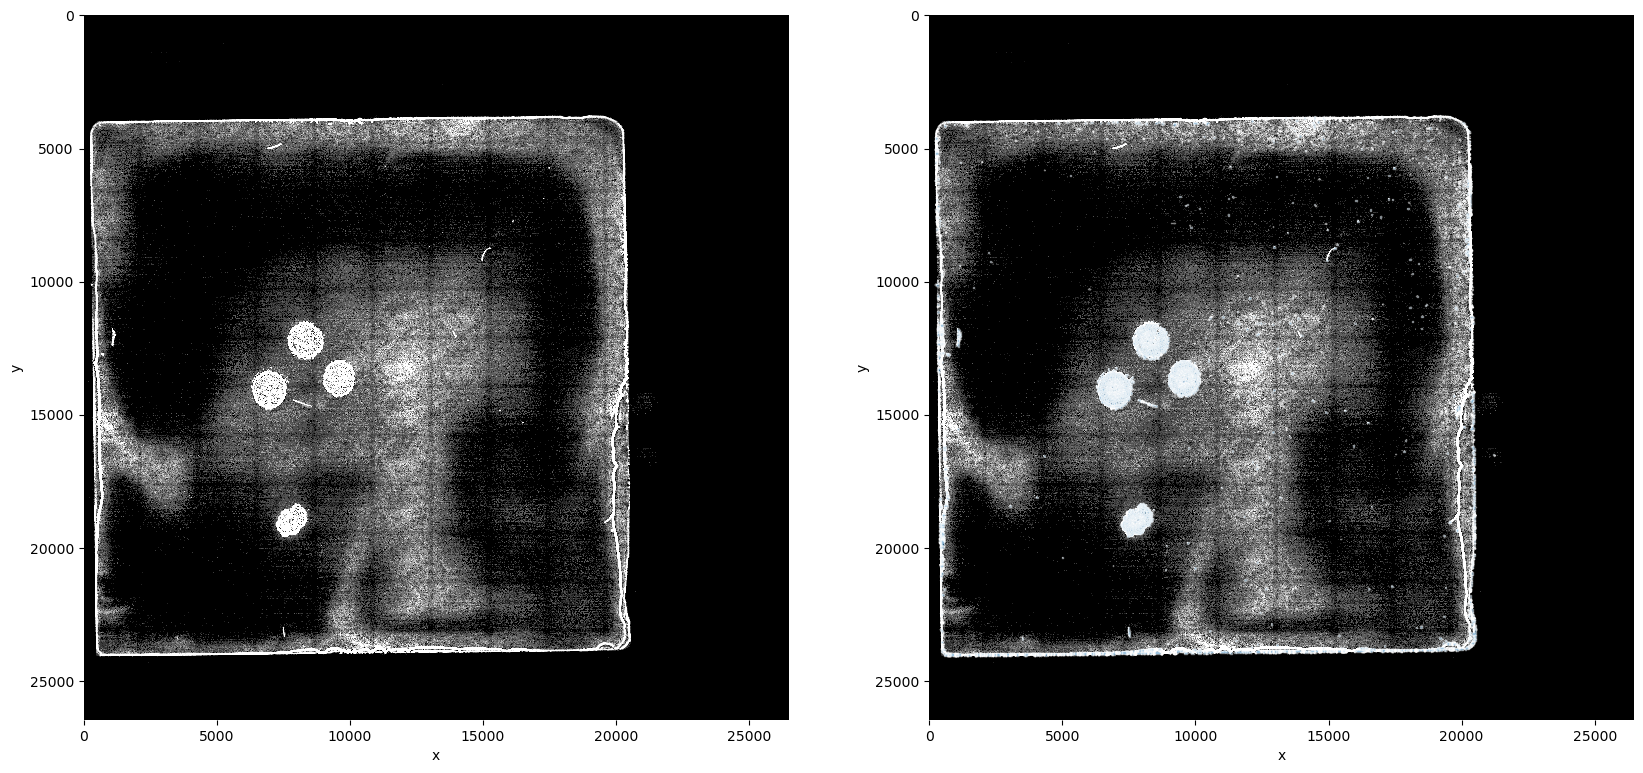

In [13]:
# Plot segmented image
fc.segmentationPlot(img, polygons = polygons)

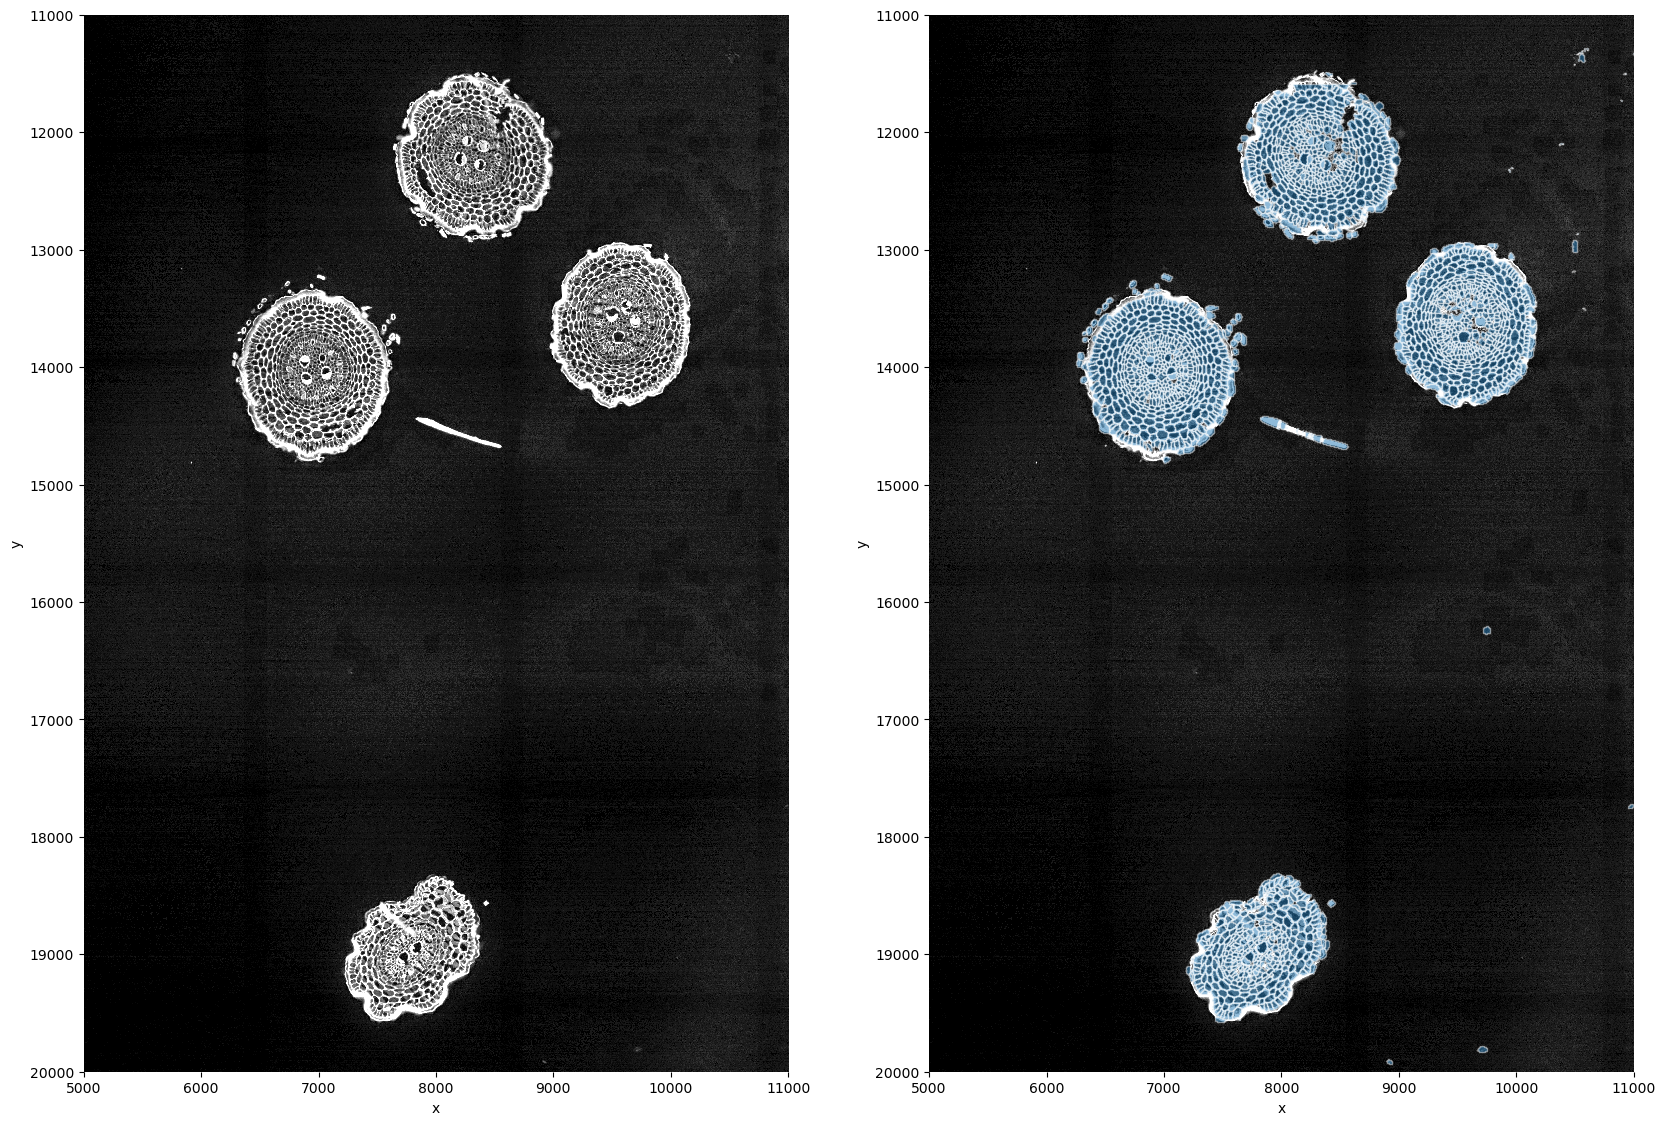

In [14]:
# Plot zoomed-in
fc.segmentationPlot(img, polygons = polygons, crd = crd_list)

# Prepare AnnData

In [18]:
# Create the anndata with transcripts allocated to cells 
adata,df = fc.allocation(ddf,
                         ic       = img_wall_clean_ic,
                         masks    = masks,
                         radius   = 0,
                         polygons = polygons
                         )

D:\Master\Workspace\P04_STEREO-seq\napari-sparrow_test\napari-sparrow-lottep\src\napari_sparrow\functions.py:564: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = AnnData(cell_counts[cell_counts.index != 0])
c:\Users\vincentp\miniconda3\envs\napari-sparrow\lib\site-packages\anndata\_core\anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


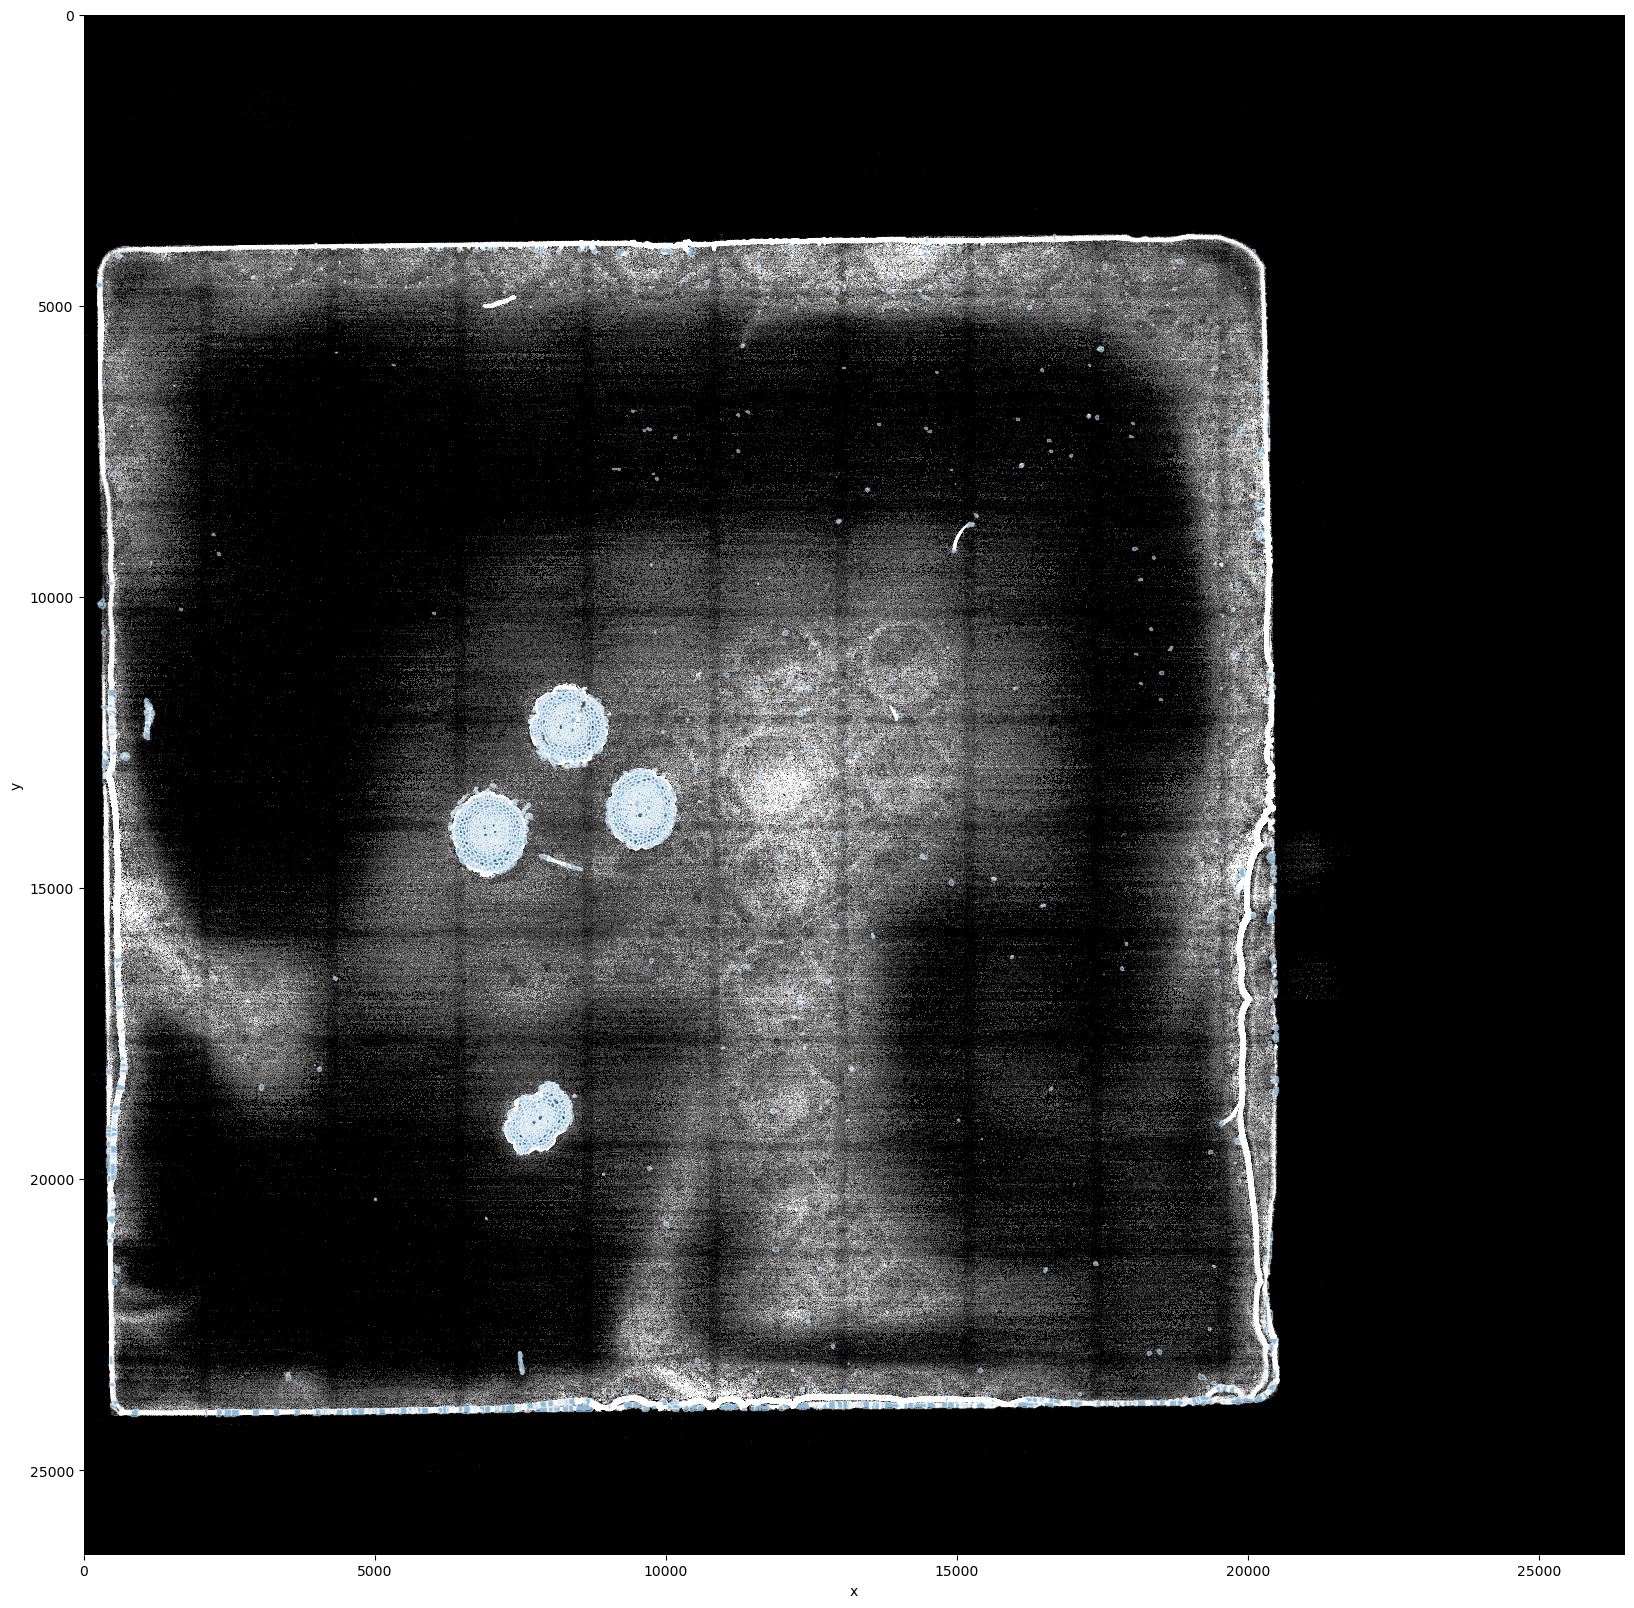

In [19]:
fc.plot_shapes(adata, img = img_wall_clean_ic)

In [20]:
# Convert 'spatial' to dataframe?
adata.obsm['spatial'] = pd.DataFrame(adata.obsm['spatial'],
                                     columns = ['x','y'],
                                     index   = adata.obs.index)

In [ ]:
# Save AnnData (only on first run)
name_slide = 'adata'
fc.save_data(adata,
             "stash/" + name_slide + ".geojson",
             "stash/" + name_slide + ".h5ad")